In [1]:
import os
from getpass import getpass

os.environ['TD_API_KEY'] = getpass('Enter TD API KEY ')

Enter TD API KEY ········


In [2]:
os.environ['TD_API_SERVER'] = 'https://api.treasuredata.com'

In [3]:
import pytd

In [4]:
client = pytd.Client(database='sample_datasets')

In [5]:
client.query('select code, count(1) as cnt from www_access group by 1 order by 2 desc')

{'data': [[200, 4981], [404, 17], [500, 2]], 'columns': ['code', 'cnt']}

In [6]:
import pandas as pd

res = client.query('select * from www_access')
df = pd.DataFrame(**res)
df.head()

,host,path,method,referer,code,agent,user,size,time
0,64.123.77.92,/category/electronics,GET,-,200,Mozilla/5.0 (Windows NT 6.0; rv:10.0.1) Gecko/...,-,43,1412348399
1,152.213.30.31,/item/software/228,GET,/category/software,200,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-,54,1412348384
2,140.36.216.47,/category/electronics,GET,/category/computers,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,-,104,1412348369
3,216.30.183.160,/category/software,GET,-,200,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,-,135,1412348355
4,68.111.93.128,/category/games,GET,/category/software,200,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,-,103,1412348340


<AxesSubplot:>

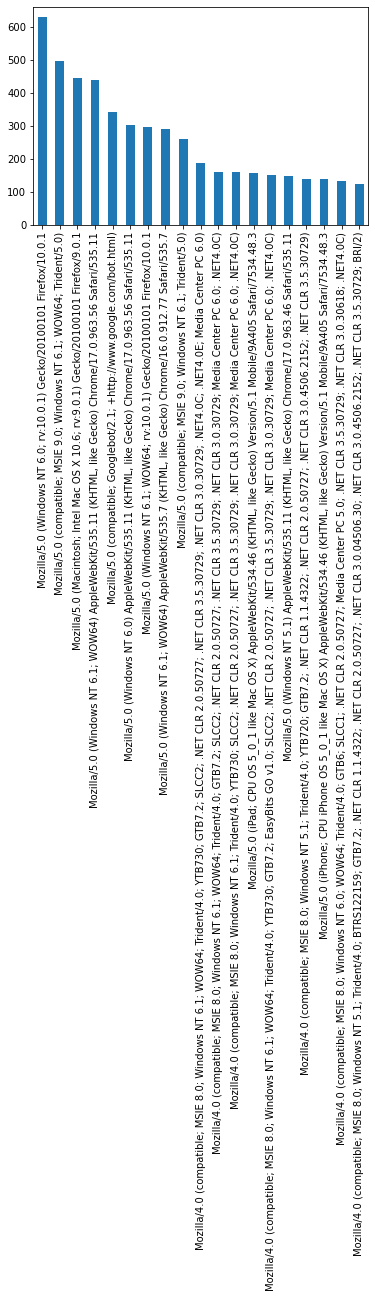

In [7]:
df['agent'].value_counts().plot(kind='bar')

In [8]:
client.query('select hivemall_version()', engine='hive')

returning `tdclient.cursor.Cursor`. This cursor, `Cursor#fetchone` in particular, might behave different from your expectation, because it actually executes a job on Treasure Data and fetches all records at once from the job result.


{'data': [['0.6.2-202105-r01']], 'columns': ['_c0']}

In [9]:
import time

client.query('select 1', 
             engine='hive', 
             db='sample_datasets', 
             priority=-1, 
             wait_callback=lambda obj: print('[{}] waiting with {}'.format(int(time.time()), obj)), 
             wait_interval=2)

returning `tdclient.cursor.Cursor`. This cursor, `Cursor#fetchone` in particular, might behave different from your expectation, because it actually executes a job on Treasure Data and fetches all records at once from the job result.


[1659679700] waiting with <tdclient.cursor.Cursor object at 0x7fde96fd1610>
[1659679703] waiting with <tdclient.cursor.Cursor object at 0x7fde96fd1610>
[1659679705] waiting with <tdclient.cursor.Cursor object at 0x7fde96fd1610>
[1659679707] waiting with <tdclient.cursor.Cursor object at 0x7fde96fd1610>
[1659679709] waiting with <tdclient.cursor.Cursor object at 0x7fde96fd1610>
[1659679711] waiting with <tdclient.cursor.Cursor object at 0x7fde96fd1610>
[1659679714] waiting with <tdclient.cursor.Cursor object at 0x7fde96fd1610>
[1659679716] waiting with <tdclient.cursor.Cursor object at 0x7fde96fd1610>
[1659679718] waiting with <tdclient.cursor.Cursor object at 0x7fde96fd1610>
[1659679720] waiting with <tdclient.cursor.Cursor object at 0x7fde96fd1610>


{'data': [[1]], 'columns': ['_c0']}

In [11]:
df_iris = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
df_iris.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
database, table = 'takuti', 'demo'

In [ ]:
client.create_database_if_not_exists(database)

In [ ]:
destination = '{}.{}'.format(database, table)
destination

In [ ]:
client.load_table_from_dataframe(df_iris, destination, writer='spark', if_exists='overwrite')

In [ ]:
pd.DataFrame(**client.query('select * from {}'.format(destination))).head()

In [12]:
!pip install memory_profiler
%load_ext memory_profiler

  Preparing metadata (setup.py) ... done
  Created wheel for memory_profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31282 sha256=a2a4053c1d5a2d9c9d47bc60eff711ce43b70083a62124901dc8c20a73615261
  Stored in directory: /Users/solution/Library/Caches/pip/wheels/0c/46/40/2be5888425b5058e7a3205875fda2ecf2219e515ad89dca951
Successfully built memory_profiler

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
%%time
%%memit
client.load_table_from_dataframe(df_iris, destination, writer='bulk_import', if_exists='overwrite')

In [ ]:
%%time
%%memit
client.load_table_from_dataframe(df_iris, destination, writer='insert_into', if_exists='overwrite')

In [ ]:
%%time
%%memit
client.load_table_from_dataframe(df_iris, destination, writer='spark', if_exists='overwrite')

In [ ]:
%%time
%%memit
client.load_table_from_dataframe(df_iris, destination, writer='spark', if_exists='overwrite')

In [13]:
from pytd.dbapi import connect

conn = connect(pytd.Client(database='sample_datasets'))

In [14]:
def query(sql, connection):
    cur = connection.cursor()
    cur.execute(sql)
    rows = cur.fetchall()
    columns = [desc[0] for desc in cur.description]
    return {'data': rows, 'columns': columns}

query('select code, count(1) as cnt from www_access group by 1 order by 2 desc', conn)

{'data': [[200, 4981], [404, 17], [500, 2]], 'columns': ['code', 'cnt']}

In [15]:
def iterrows(sql, connection):
    cur = connection.cursor()
    cur.execute(sql)
    index = 0
    columns = None
    while True:
        row = cur.fetchone()
        if row is None:
            break
        if columns is None:
            columns = [desc[0] for desc in cur.description]
        yield index, dict(zip(columns, row))
        index += 1

for index, row in iterrows('select code, count(1) as cnt from www_access group by 1 order by 2 desc', conn):
    print(index, row)

0 {'code': 200, 'cnt': 4981}
1 {'code': 404, 'cnt': 17}
2 {'code': 500, 'cnt': 2}


In [16]:
connect(pytd.Client(database='sample_datasets', default_engine='hive')).cursor()

returning `tdclient.cursor.Cursor`. This cursor, `Cursor#fetchone` in particular, might behave different from your expectation, because it actually executes a job on Treasure Data and fetches all records at once from the job result.


In [17]:
import pytd.pandas_td as td

In [18]:
engine = td.create_engine('presto:sample_datasets')

In [ ]:
query = """
select time, close from nasdaq where symbol='AAPL'
"""

# Run a query, converting "time" to a time series index
df = td.read_td_query(query, engine, index_col='time', parse_dates={'time': 's'})
df.head()